In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
# from scipy import sparse
from sklearn.decomposition import PCA # TruncatedSVD
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score
import import_ipynb # so .ipynb can be imported
from PCA_heatmap_bin_cells_filtered import get_X_labels_lens
import pickle

# binary data (bin)
my_filepath = "/Users/kinichen/UTSSRP/Tuzhilina_Project/UTSSRP-github/contact_dict_bin_cells_filtered.pkl"

In [13]:
if __name__ == "__main__":

	with open(my_filepath, "rb") as f:
		contact_dict = pickle.load(f)


	X, cell_labels, labels, chr_lens = get_X_labels_lens(contact_dict)

	pca = PCA(n_components=300)	
	X_pca = pca.fit_transform(X)

In [14]:
def evaluate_performance(true_labels, pred_labels, X_reduced): # metrics
	# ARI: adjusts for chance. 1 = good; 0 = random labelling
	print(f"Kmeans ARI score: {adjusted_rand_score(true_labels, pred_labels):.2f}")

	# NMI: 0 (no mutual information between cluster and true labels) and 1 (perfect correlation)
	print(f"Normalized Mutual Information (NMI): {normalized_mutual_info_score(true_labels, 
		pred_labels):.2f}")

	# Silhouette: additional metric that doesn't even need true labels (unsupervised evaluation)
	# near 1 = good; 0 = overlap; -1 = bad clustering
	print(f"Kmeans Silhouette Score: {silhouette_score(X_reduced, pred_labels):.2f}")

In [15]:
# find KMeans cluster labels
if __name__ == "__main__":
	num_clusters = len(np.unique(labels))

	kmeans = KMeans(init="random", n_clusters=num_clusters, 
					random_state=0, n_init=10)

	labels_pred = kmeans.fit_predict(X_pca)


	# evaluate clustering performance 
	true_type_labels = labels
	evaluate_performance(true_type_labels, labels_pred, X_reduced=X_pca)

Kmeans ARI score: 0.05
Normalized Mutual Information (NMI): 0.09
Kmeans Silhouette Score: 0.14


In [16]:
# Helper functions for clustering/metrics visualization if wanted
def visualize_kmeans(data, n_clusters):
	"""
	This function performs k-means clustering and visualizes the data with a decision boundary.
	data: array-like, shape (n_samples, n_features)
	n_clusters: int, number of clusters
	"""
	# reduce the data to 2D for visualization
	'''
	data_scaled = StandardScaler.fit_transform(data)
	pca = PCA(n_components=2)
	reduced_data = pca.fit_transform(data_scaled)
	''' 
	
	pca = PCA(n_components=2)	
	reduced_data = pca.fit_transform(data)

	kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4)
	kmeans.fit(reduced_data)

	# Step size of the mesh. Decrease to increase the quality of the VQ.
	h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

	# Plot the decision boundary. For that, we will assign a color to each
	x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
	y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
	xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

	# Obtain labels for each point in mesh. Use last trained model.
	# Probably want to sort this to get sorted cluster order

	Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
	# Put the result into a color plot
	Z = Z.reshape(xx.shape)
	plt.figure()
	plt.clf()
	plt.imshow(
		Z,
		interpolation="nearest",
		extent=(xx.min(), xx.max(), yy.min(), yy.max()),
		cmap=plt.cm.Paired,
		aspect="auto",
		origin="lower",
	)

	plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
	# Plot the centroids as a white X
	centroids = kmeans.cluster_centers_
	plt.scatter(
		centroids[:, 0],
		centroids[:, 1],
		marker="x",
		s=169,
		linewidths=3,
		color="w",
		zorder=10,
	)

	plt.title(
		"K-means clustering on the data (PCA-reduced data)\n"
		"Centroids are marked with white cross"
	)
	plt.xlim(x_min, x_max)
	plt.ylim(y_min, y_max)
	plt.xticks(())
	plt.yticks(())

	plt.show()




def plot_evaluation_scores(
	X,
	y,
	n_clusters_range,
	metric,
	method="KMeans" 	# "KMeans" or "Spectral"
):
	"""
	This function plots the ARI and silhouette scores for different number of clusters
	n_clusters_range: range, the range of number of clusters to evaluate
	metric: str, the metric to use, either "ARI" or "silhouette"
	"""

	scores = []
	for n_clusters in n_clusters_range:
		if method == "KMeans":
			labels_pred = KMeans(init="random", n_clusters=n_clusters, n_init=10).fit_predict(X)
		elif method == "Spectral":
			labels_pred = SpectralClustering(
			n_clusters=n_clusters, 
			affinity='nearest_neighbors', 
			n_neighbors=10,
			assign_labels='kmeans',
			random_state=42
		).fit_predict(X)
		else:
			raise ValueError("Unsupported algorithm. Choose 'KMeans' or 'Spectral'.")

   
		if metric == "ARI":
			scores.append(adjusted_rand_score(y, labels_pred))
		elif metric == "NMI":
			scores.append(normalized_mutual_info_score(y, labels_pred))
		elif metric == "silhouette":
			scores.append(silhouette_score(X, labels_pred))

	plt.figure()
	plt.plot(n_clusters_range, scores)
	plt.xlabel("Number of clusters")
	plt.ylabel("Score")
	plt.title(f"Performance of {method} clustering using {metric} score")
	plt.show()

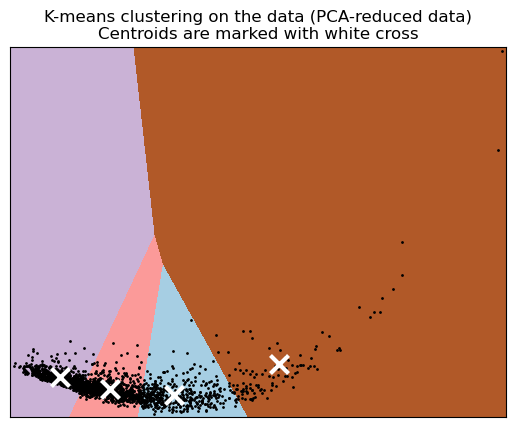

In [17]:
# Biplot visualization with kmeans clustering in 2D space 
# apply on X without PCA (done in function)
if __name__ == "__main__":
	visualize_kmeans(data=X, n_clusters=num_clusters) # number of cell types

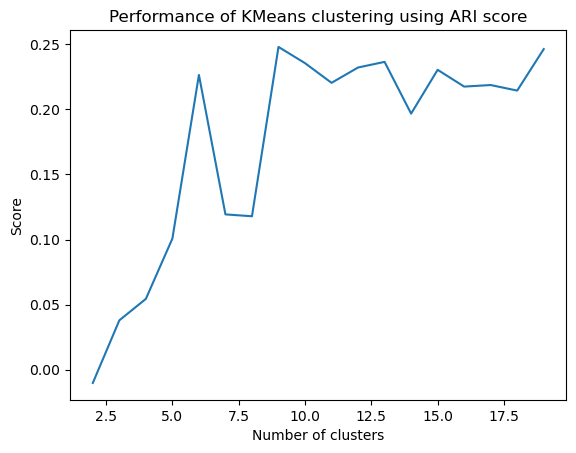

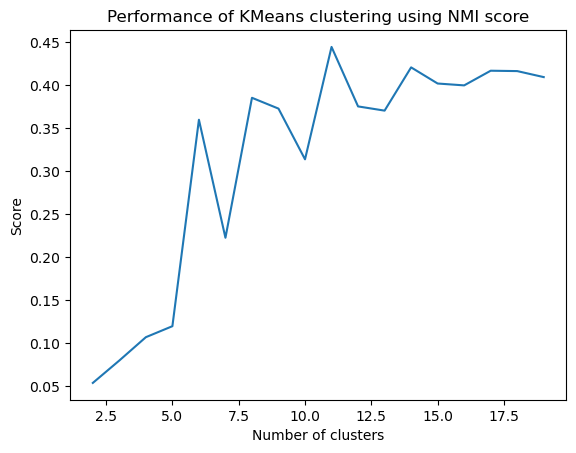

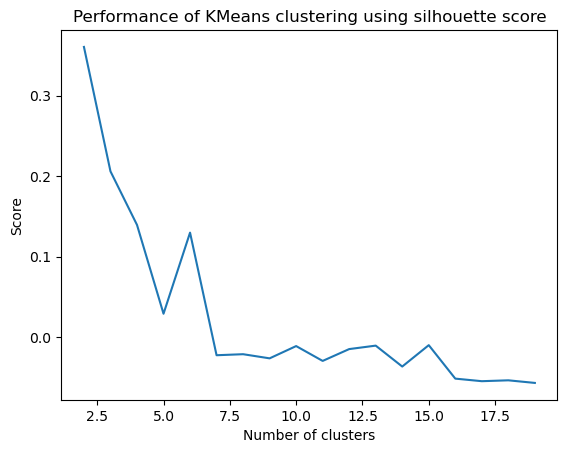

In [18]:
# Visualizing metrics for each number of clusters choice
if __name__ == "__main__":
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="ARI")
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="NMI")
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="silhouette")

In [19]:
# Try spectral clustering (on original and PCA-reduced data)
if __name__ == "__main__":
	spectral = SpectralClustering(
		n_clusters=num_clusters,
		affinity='nearest_neighbors',  # or 'rbf' or 'precomputed'
		n_neighbors=10,
		assign_labels='kmeans',
		random_state=42			# seed for reproducibility
	)

	labels_pred = spectral.fit_predict(X_pca)
	evaluate_performance(true_type_labels, labels_pred, X_reduced=X_pca)

Kmeans ARI score: 0.43
Normalized Mutual Information (NMI): 0.52
Kmeans Silhouette Score: -0.11


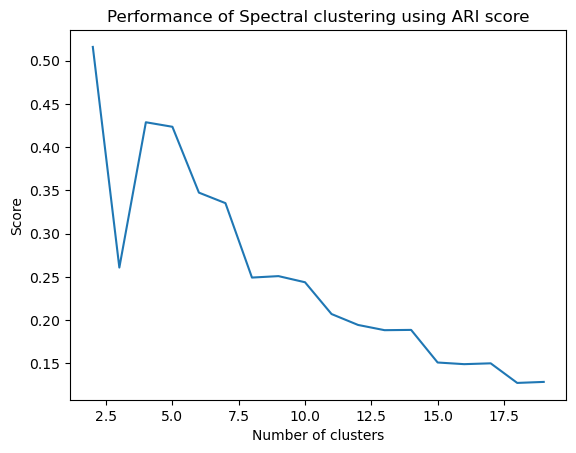

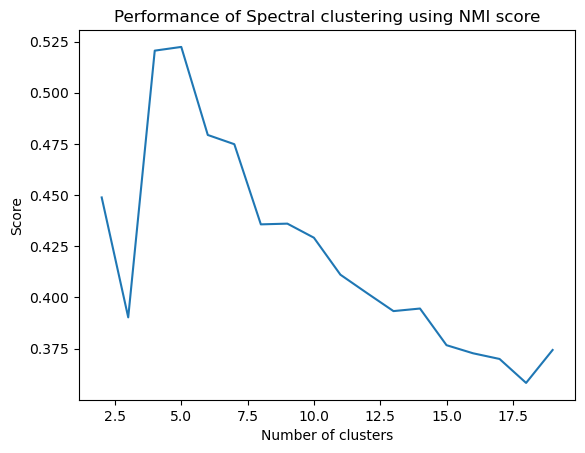

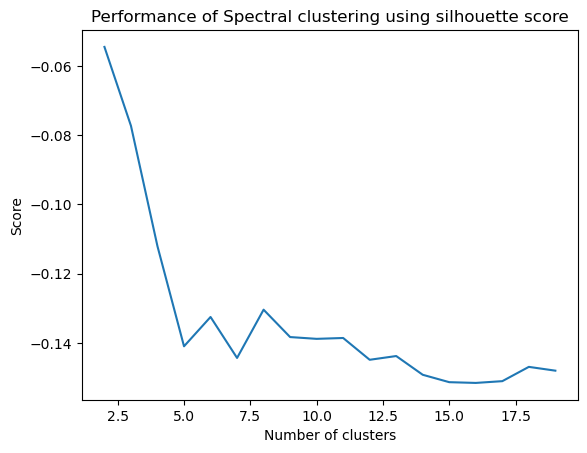

In [20]:
if __name__ == "__main__":
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="ARI", method="Spectral")
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="NMI", method="Spectral")
	plot_evaluation_scores(X_pca, true_type_labels, n_clusters_range=range(2, 20), metric="silhouette", method="Spectral")